# **Title**

## **Introduction**

The project presented in this report examines how people play video games, focusing specifically on Minecraft. The data for our analysis was provided by the computer science department at UBC, which set up a Minecraft server to study player behaviors and patterns. The server tracks each player's activity as they navigate through the game world, aiming to uncover habits and trends in how people interact with the game.

The primary objective of this initiative is to better understand the player base, identify target demographics for recruitment, and ensure the server can accommodate sufficient licenses to handle the number of participants. To streamline their recruitment process and optimize resources, the project team, led by Frank Wood, is exploring several questions about the collected data.

Our group’s contribution to this effort is focused on answering the question: **How does age predict the session length of a player?** This inquiry is critical for understanding how age influences player engagement and can help refine strategies for server management and recruitment. To address this question, we utilized two datasets: the **“sessions”** dataset, which logs player activity in the game, and the **“players”** dataset, which provides demographic and attribute information about the players.


# **Methods and Results** 


#### We start by loading the software from the library 

In [32]:
library(tidyverse)
library(repr)
library(readxl) 
library(lubridate) 
library(ggplot2) 
library(tidymodels)
options(repr.matrix.max.rows = 6)

#### Now we will download the `sessions.csv` and `players.csv` files 

In [31]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz" 
players_df <- read_csv(url) 

url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB" 
sessions_df <- read_csv(url) 


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## **Data Wrangling** 

This section outlines the steps taken to prepare the data for analysis, including merging datasets, calculating session length, and filtering outliers.

---

## Steps:

### 1. Merging Datasets
We merged the `players.csv` and `sessions.csv` datasets using the `hashedEmail` column as the key. This allowed us to associate session data (e.g., session times) with player attributes (e.g., age, experience). Combining these datasets enabled us to analyze how player demographics, specifically age, influence session length.

In [9]:
# Merging players and sessions datasets on 'hashedEmail'
merged_data <- merge(players_df, sessions_df, by = "hashedEmail")

### 2. Calculating Session Length
To measure player engagement, we calculated the session length by subtracting `start_time` from `end_time`. This gave us the duration of each session in minutes, which is the dependent variable in our analysis. 

In [10]:
# Convert 'start_time' and 'end_time' to datetime
merged_data$start_time <- as.POSIXct(merged_data$start_time, format = "%d/%m/%Y %H:%M")
merged_data$end_time <- as.POSIXct(merged_data$end_time, format = "%d/%m/%Y %H:%M")

# Calculate session length in minutes
merged_data$session_length <- as.numeric(difftime(merged_data$end_time, merged_data$start_time, units = "mins"))


### 3. Handling Missing Values
Rows with missing or invalid session lengths were removed to ensure the data used in the analysis was complete and accurate. Missing values in session length could indicate incomplete logs, and including them would compromise the validity of our results

In [28]:

# Remove rows with missing session_length
merged_data <- merged_data[!is.na(merged_data$session_length), ]



### 4. Filtering Outliers
We removed extreme outliers from the `session_length` and `age` variables:
- **Session Length**: Outliers were identified using the 1.5 IQR rule to exclude sessions that were unusually short or excessively long, which might skew results.
- **Age**: Values outside a plausible range (e.g., below 8 or above 99 years) were filtered, as they are unlikely to represent realistic data for Minecraft players.

In [14]:
## For session_length
# Compute IQR for session_length
Q1 <- quantile(merged_data$session_length, 0.25)
Q3 <- quantile(merged_data$session_length, 0.75)
IQR <- Q3 - Q1

# Define bounds for filtering
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR

# Filter outliers in session_length
filtered_data <- merged_data[merged_data$session_length >= lower_bound & merged_data$session_length <= upper_bound, ]

In [15]:
## For age
# Filter rows with implausible age values
filtered_data <- filtered_data[filtered_data$age >= 8 & filtered_data$age <= 99, ]

### 5. Selecting Relevant Variables
To focus our analysis, we retained only the variables essential to our research question:
- `age`: The independent variable used to predict session length.
- `session_length`: The dependent variable representing player engagement.
- `played_hours`: Total hours a player has engaged with the game, offering additional context for session behavior.
- `experience` and `subscribe`: Categorical variables providing further insights into player demographics and preferences.


In [25]:
 filtered_data <- filtered_data %>%
select(hashedEmail, age, session_length, played_hours, experience, subscribe)

# Summary statistics for key variables
summary(filtered_data[c("session_length", "age", "played_hours")])

 session_length       age         played_hours   
 Min.   :  3.0   Min.   : 8.00   Min.   :  0.00  
 1st Qu.:  9.0   1st Qu.:17.00   1st Qu.: 32.00  
 Median : 26.5   Median :17.00   Median : 56.10  
 Mean   : 42.0   Mean   :19.45   Mean   : 94.64  
 3rd Qu.: 65.0   3rd Qu.:23.00   3rd Qu.:178.20  
 Max.   :168.0   Max.   :99.00   Max.   :223.10  

In [29]:
# Display the first few rows of the filtered dataset
head(filtered_data)


,hashedEmail,age,session_length,played_hours,experience,subscribe
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,20,45,1.5,Regular,TRUE
2,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,20,61,1.5,Regular,TRUE
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,21,30,0.4,Pro,FALSE
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,17,11,0.1,Beginner,TRUE
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,17,24,5.6,Regular,TRUE
6,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,17,34,5.6,Regular,TRUE


#### What Does `filtered_data` Represent?
The `filtered_data` dataset is a cleaned and streamlined version of the raw data, containing only the relevant and reliable information needed for analysis. It includes:
- **Player Information**:
  - `age`: The age of the player.
  - `experience`: The skill level or experience of the player.
  - `subscribe`: Whether the player has an active subscription (TRUE/FALSE).
- **Session Information**:
  - `session_length`: The duration of each session in minutes, calculated as the difference between `start_time` and `end_time`.
  - `played_hours`: The total cumulative playtime for each player.

#### Importance of `filtered_data`
This dataset is now ready for exploratory data analysis and modeling. By removing irrelevant variables, addressing missing values, and excluding outliers, `filtered_data` ensures that the analysis focuses solely on meaningful and accurate relationships. Specifically, it allows us to investigate the relationship between age and session length without interference from noise or errors in the data.




## Exploratory Data Analysis

This section covers the EDA steps for understanding the relationship between `age` and `session_length`.

---



### 1. Summary Statistics

```r
# Summary statistics for key variables
summary(filtered_data[c("age", "session_length")])


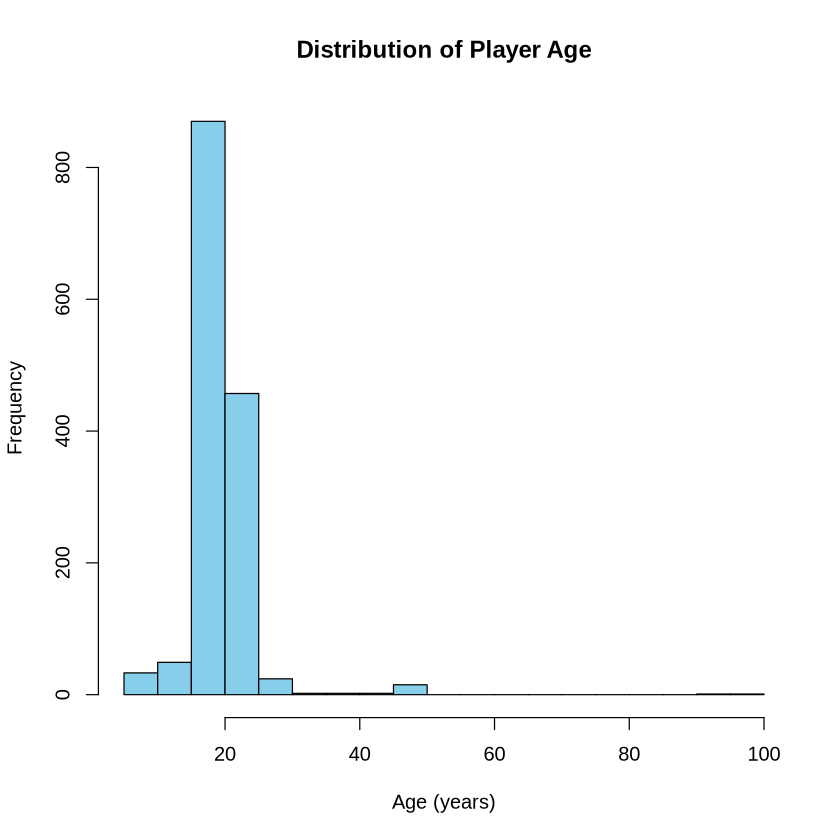

In [34]:
# Plot histogram of age
hist(
  filtered_data$age,
  breaks = 15,
  col = "skyblue",
  main = "Distribution of Player Age",
  xlab = "Age (years)",
  ylab = "Frequency",
  border = "black"
)

The histogram of player age indicates:

- **Concentration of Younger Players**: The majority of players are between **15 and 25 years old**.
- **Peak Age**: There is a noticeable peak around **17 years**, suggesting this is the most common age among players.
- **Fewer Older Players**: There is a decline in the number of players beyond 30 years, with very few players up to 99 years old.

*This distribution suggests that a younger demographic predominantly plays Minecraft.*


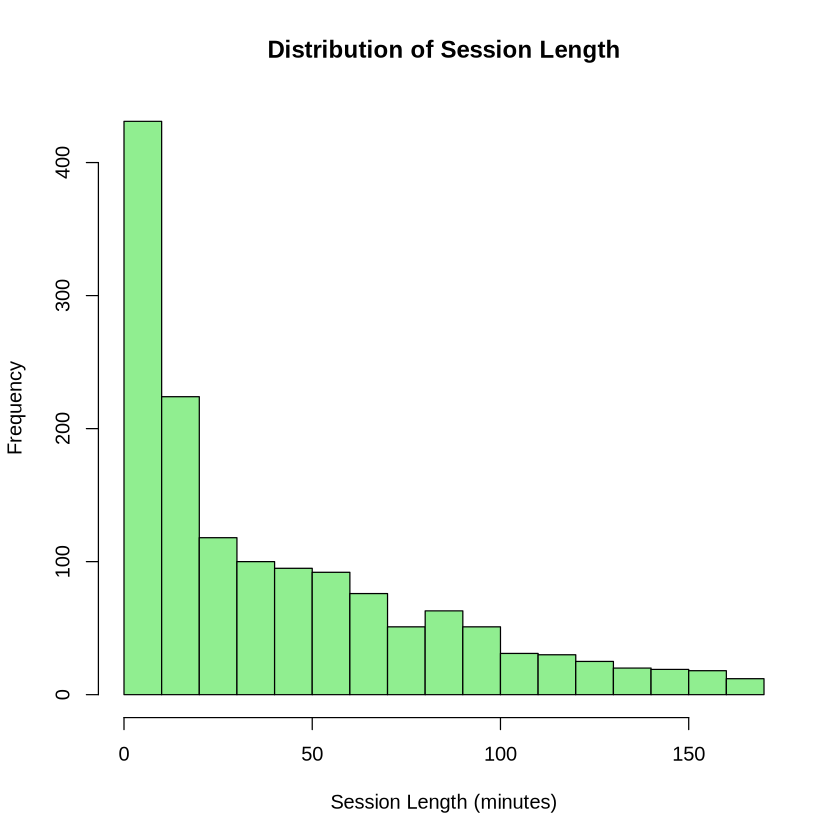

In [35]:
# Plot histogram of session length
hist(
  filtered_data$session_length,
  breaks = 15,
  col = "lightgreen",
  main = "Distribution of Session Length",
  xlab = "Session Length (minutes)",
  ylab = "Frequency",
  border = "black"
)

The histogram of session lengths shows:

- **Right-Skewed Distribution**: Most sessions are shorter, with lengths under **70 minutes**.
- **Common Session Duration**: A high frequency of sessions lasts between **10 and 30 minutes**.
- **Longer Sessions Are Rare**: While sessions can extend up to **168 minutes**, these are less common.

*This implies that players typically engage in relatively short gaming sessions.*


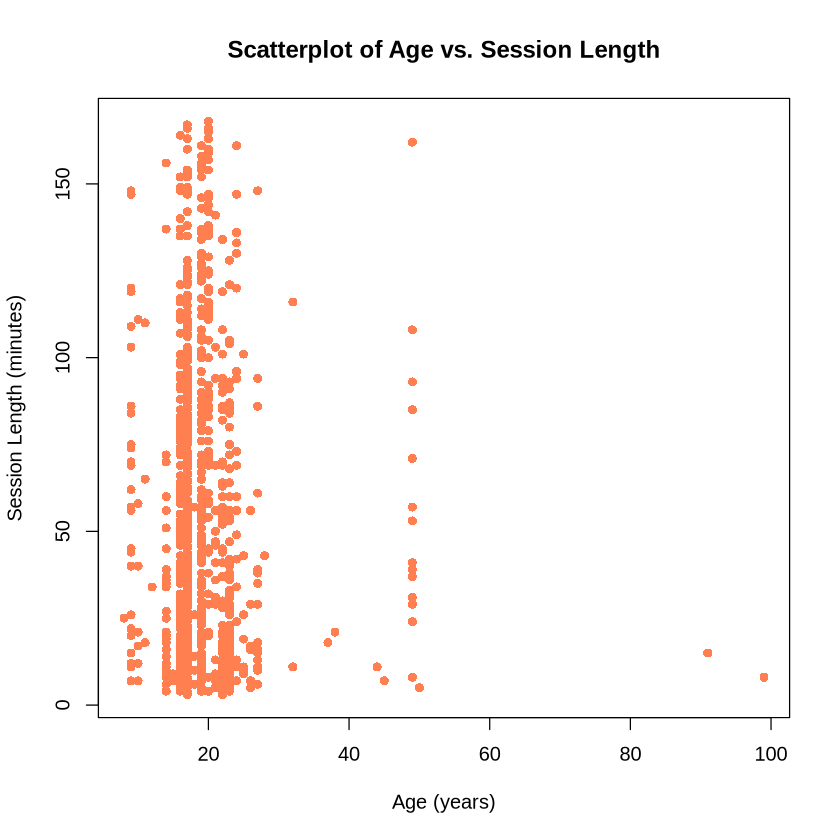

In [36]:
# Scatterplot of age vs session length
plot(
  filtered_data$age,
  filtered_data$session_length,
  col = "coral",
  main = "Scatterplot of Age vs. Session Length",
  xlab = "Age (years)",
  ylab = "Session Length (minutes)",
  pch = 16
)

The scatterplot reveals:

- **Weak Relationship**: There is a wide scatter of data points with no clear linear pattern.
- **Variability Across Ages**: Players of all ages exhibit a wide range of session lengths.
- **No Strong Predictive Trend**: Age does not appear to strongly predict session length based on the scatterplot alone.

*This suggests that age may not be a significant predictor of how long a player engages in a session, warranting further analysis through regression.*


---

## Insights

- **Overall Observation**: The preliminary analysis indicates a weak correlation between age and session length.
- **Potential Factors**: Other variables, such as player experience or subscription status, might influence session length more significantly.
- **Next Steps**: Proceed to regression analysis to quantitatively assess the relationship between age and session length.

These findings provide a foundational understanding of the data and guide the subsequent steps in our analysis.

# Regression Analysis

## Step 1: Data Splitting

We split the cleaned dataset into **training** and **testing** sets to build and evaluate the regression model:
- **Training Data**: 75% of the data, used to fit the model.
- **Testing Data**: 25% of the data, used to evaluate model performance.


In [52]:
# Step 1: Data Splitting
set.seed(7)  # For reproducibility
data_split <- initial_split(filtered_data, prop = 0.75, strata = session_length)
train_data <- training(data_split)
test_data <- testing(data_split)

## Step 2: Model Specification and Fitting
We defined a linear regression model to predict `session_length` based on `age`. A recipe specifying the formula was created, and the model was fit using the **training data**.

In [51]:

# Step 2: Model Specification and Recipe
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(session_length ~ age, data = train_data)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = train_data)

# Display the model fit
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    58.6582      -0.8521  


## Step 3: Model Evaluation
The fitted model was used to predict `session_length` on the testing data. We evaluated the model’s performance using metrics such as **Root Mean Square Percentage Error (RMSPE) and R-squared**.

In [50]:
lm_test_results <- lm_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = session_length, estimate = .pred)

# Display test results
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,39.70454398
rsq,standard,0.01116709
mae,standard,32.58628112


## Step 4: Visualization
We plotted a scatterplot of `age` vs. `session_length` and overlayed the regression line using predictions from the model. This visualization helps to interpret the relationship between `age` and `session_length`.



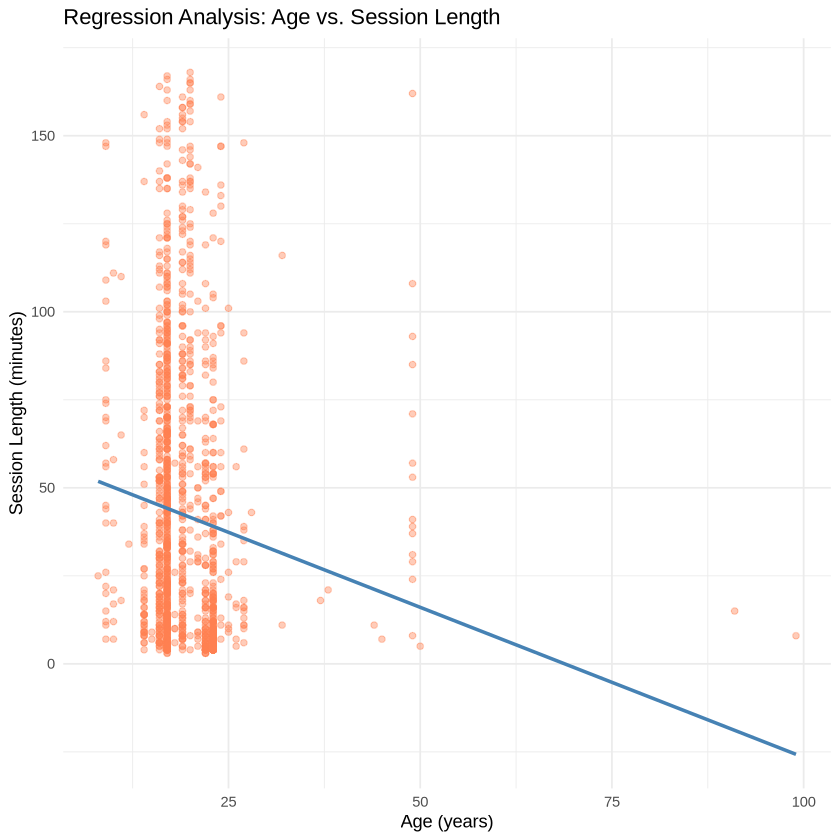

In [49]:
# Create a prediction grid for age
age_prediction_grid <- tibble(
  age = seq(min(filtered_data$age), max(filtered_data$age), length.out = 100)
)

# Generate predictions for the regression line
regression_preds <- lm_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

# Plot the regression results
lm_plot_final <- ggplot(filtered_data, aes(x = age, y = session_length)) +
  geom_point(alpha = 0.4, color = "coral") +
  geom_line(data = regression_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue", linewidth = 1) +
  labs(
    title = "Regression Analysis: Age vs. Session Length",
    x = "Age (years)",
    y = "Session Length (minutes)"
  ) +
  theme_minimal()

lm_plot_final
